In [2]:
import numpy as np
import pickle as pkl
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
import matplotlib.patches as patches
import os
import sys
sys.path.append('/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/')
import other_billeh_utils
import sklearn
import skimage
from skimage.measure import label, regionprops

2024-09-30 14:29:53.704857: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 14:29:53.786866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 14:29:53.786909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 14:29:53.788226: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 14:29:53.805183: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 14:29:53.806062: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# Load the csv with data
df_v1 = pd.read_csv("/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Benchmark_models/v1_100000_lm_30000/v1_features_df.csv", delimiter=',')
df_lm = pd.read_csv("/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Benchmark_models/v1_100000_lm_30000/lm_features_df.csv", delimiter=',')

# Load data

## Without trials

In [9]:
# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_sums = np.zeros((n_rows, n_cols, n_neurons_v1)) # sum of all spikes per neuron and position
lm_all = np.zeros((n_rows, n_cols, n_neurons_lm)) # sum of all spikes per neuron and position

for col in tqdm(range(n_cols)):
    for row in range(n_rows):
        data_file = 'Data_connected/simulation_data_row_'+str(row)+'_col_'+str(col)+'_r10.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(row)+'_'+str(col)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            v1_sums[row, col, :] += np.sum(v1[:, time_bin[0]:time_bin[1]], axis=(0,1))
            lm_all[row, col, :] += np.sum(lm[:, time_bin[0]:time_bin[1]], axis=(0,1))

# save the data
with open('Data_connected/v1_sums.pkl', 'wb') as f:
    pkl.dump(v1_sums, f)

with open('Data_connected/lm_sums.pkl', 'wb') as f:
    pkl.dump(lm_all, f)

print('Data saved')

time-steps of stimulus 1000


100%|██████████| 11/11 [34:29<00:00, 188.10s/it]

Data saved


## With trials

In [15]:
# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414
# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])
print("time-steps of stimulus", n_timesteps)
v1_sums_trials = np.zeros((n_rows, n_cols, n_trials, n_neurons_v1)) # sum of all spikes per neuron and position
lm_all_trials = np.zeros((n_rows, n_cols, n_trials, n_neurons_lm)) # sum of all spikes per neuron and position

for col in tqdm(range(n_cols)):
    for row in range(n_rows):
        data_file = 'Data_connected/simulation_data_row_'+str(row)+'_col_'+str(col)+'_r10.hdf5'

        # Open the file in read mode
        file = h5py.File(data_file, 'r')

        # Access the 'Data' group
        data_group = file['Data']

        data = {}

        # Loop over the subgroups ('v1', 'lm', 'LGN')
        for subgroup_name in data_group.keys():
            # Access the subgroup
            subgroup = data_group[subgroup_name]
            
            # Access the 'z' dataset in the subgroup
            name = str(row)+'_'+str(col)
            dataset = subgroup[name] 
            
            # Convert the dataset to a numpy array and store it in the dictionary
            data[subgroup_name] = np.array(dataset)

        # Close the file
        file.close()

        v1 = data['v1']
        lm = data['lm']
        LGN = data['LGN']

        for time_bin in time_bins:
            for trial in range(n_trials):
                v1_sums_trials[row, col, trial, :] += np.sum(v1[trial, time_bin[0]:time_bin[1]], axis=(0))
                lm_all_trials[row, col, trial, :] += np.sum(lm[trial, time_bin[0]:time_bin[1]], axis=(0))

# save the data
with open('Data_connected/v1_sums_trials.pkl', 'wb') as f:
    pkl.dump(v1_sums_trials, f)

with open('Data_connected/lm_sums_trials.pkl', 'wb') as f:
     pkl.dump(lm_all_trials, f)

print('Data saved')

# remember v1 and lm are structured as (trials, time, neurons)

time-steps of stimulus 1000


100%|██████████| 11/11 [33:51<00:00, 184.67s/it]


Data saved


In [3]:
# Sanity check that there are 50 trials in every position
# load data
with open('Data_connected/v1_sums_trials.pkl', 'rb') as f:
    v1_sums_trials = pkl.load(f)

with open('Data_connected/lm_sums_trials.pkl', 'rb') as f:
    lm_all_trials = pkl.load(f)

# check that there are 50 trials in every position
print("number of trials in v1", np.shape(v1_sums_trials))
print("number of trials in lm", np.shape(lm_all_trials))

number of trials in v1 (13, 11, 50, 51978)
number of trials in lm (13, 11, 50, 7414)


# Plot RF individual neurons

In [4]:
# select a neuron
neuron_id = 20201 #2342

# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414

# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])

# load the data
with open('Data_connected/v1_sums.pkl', 'rb') as f:
    v1_sums = pkl.load(f)

with open('Data_connected/lm_sums.pkl', 'rb') as f:
    lm_all = pkl.load(f)

with open('Data_disconnected/v1_sums.pkl', 'rb') as f:
     v1_sums_dis = pkl.load(f)

# select disconnected or connected
# v1_sums = v1_sums_dis
# lm_all = lm_all_dis

# normalize v1 with the number of trials and time bins to get an average firing rate per neuron, multiply by 1000 to get Hz
v1_sums = v1_sums / (n_trials * n_timesteps) * 1000
lm_all = lm_all / (n_trials * n_timesteps) * 1000
v1_sums_dis = v1_sums_dis / (n_trials * n_timesteps) * 1000

# get neuron's position
cache_path = '/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/Model_utils/.cache/lm_v1_network_v1_100000_lm_30000.pkl'
with open(cache_path, 'rb') as f:
    networks, lgn_inputs, bkg_inputs = pkl.load(f)

# in networks['v1'] 'x' and 'z' are the 2 radial coordinates, and y is the depth in the column which I don't need
v1_positions_x = np.array(networks['v1']['x'])
v1_positions_z = np.array(networks['v1']['z'])

# filter only core neurons that follow r = np.sqrt(x ** 2 + z ** 2) < 400
r = np.sqrt(v1_positions_x ** 2 + v1_positions_z ** 2)
selected_mask = r < 400
v1_positions_x_core = v1_positions_x[selected_mask]
v1_positions_z_core = v1_positions_z[selected_mask]

# get the position of the neuron
neuron_pos = v1_positions_x_core[neuron_id], v1_positions_z_core[neuron_id]

neuron_pos = ((neuron_pos[0]/1000 * 70/10)+6.5, (neuron_pos[1]/1000 * 40/10)+5.5) # neuron projection to visual space

print('Neuron position:', neuron_pos)

# obtain an array with all neurons positions
neurons_positions = np.zeros((n_neurons_v1, 2))
for id in range(n_neurons_v1):
    neuron_pos = v1_positions_x_core[id], v1_positions_z_core[id]
    neuron_pos = ((neuron_pos[0]/1000 * 70/10)+6.5, (neuron_pos[1]/1000 * 40/10)+5.5) # neuron projection to visual space
    neurons_positions[id] = neuron_pos

# Create the neuron types mask
# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

# get the neuron type of the selected neuron
neuron_type = cell_types_v1[neuron_id]

print('Neuron type:', neuron_type)

Neuron position: (6.533843221187592, 6.237490295410156)
Neuron type: L4 Exc


Expected value: 1.72
std: 0.1550407530044296
mad: 0.08000000000000007
Minimum value: 1.38
Positions above std: (array([5, 5, 6, 6, 7, 7, 8]), array([6, 7, 5, 6, 4, 5, 5]))
Length above std: 7
Positions below std: (array([7]), array([7]))
Length below std: 1
Non-inverse RF


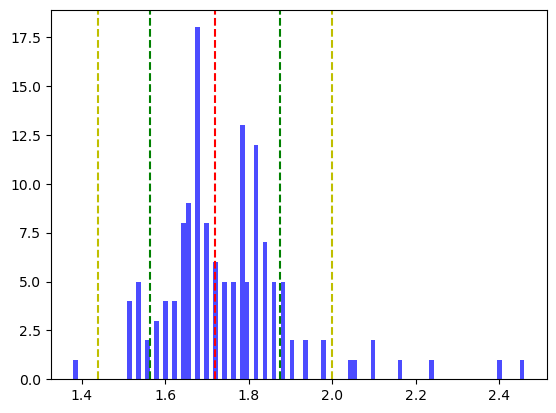

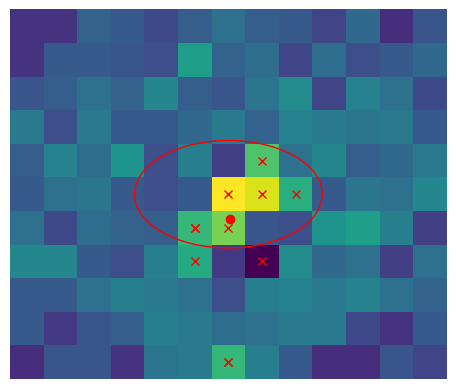

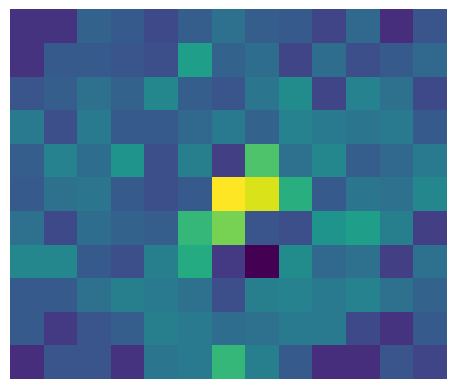

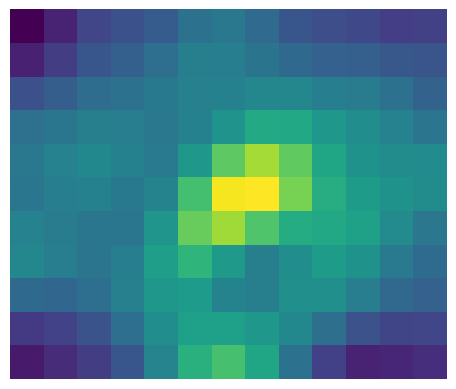

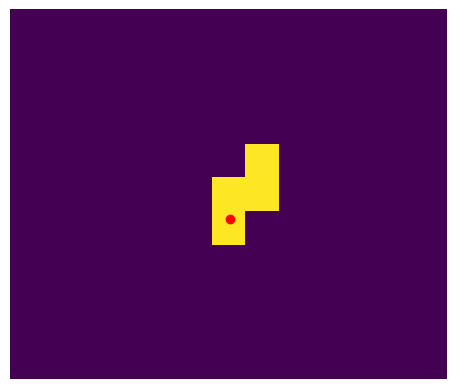

Center of mass: (7.0, 5.5)

Area: 4
Area threshold: 1.924067140867997


In [5]:
# select the given neuron
v1_neuron = np.copy(v1_sums[:,:,neuron_id]) # 1

# set 0.0 values to percentile median
expected_value = np.median(v1_neuron)
v1_neuron[np.round(v1_neuron) == 0.0] = expected_value

expected_value = np.median(v1_neuron)
std = np.std(v1_neuron)
mad = np.median(np.abs(v1_neuron - expected_value))
print("Expected value:", expected_value)
print("std:", std)
print("mad:", mad)

# plot histogram of the neuron
plt.figure()
plt.hist(v1_neuron.flatten(), bins=100, color='b', alpha=0.7)
print("Minimum value:", np.min(v1_neuron))
# plot mean and std
plt.axvline(expected_value, color='r', linestyle='--')
plt.axvline(expected_value + std, color='g', linestyle='--')
plt.axvline(expected_value - std, color='g', linestyle='--')
plt.axvline(expected_value + mad*3.5, color='y', linestyle='--')
plt.axvline(expected_value - mad*3.5, color='y', linestyle='--')

# obtain list of positions above and below the std
above_std = v1_neuron[v1_neuron > expected_value + mad*3.5]
below_std = v1_neuron[v1_neuron < expected_value - mad*3.5]

# create two new heatmaps with 1 in the given positions and 0 in the rest of them
above_std_map_binary = np.zeros(v1_neuron.shape)
below_std_map_binary = np.zeros(v1_neuron.shape)
# merge
above_below_std = np.concatenate((above_std, below_std))

if len(above_std) > 0:
    for i in range(len(above_std)):
        idx = np.where(v1_neuron == above_std[i])
        above_std_map_binary[idx] = 1

    # labelling connected components
    above_std_map = skimage.measure.label(above_std_map_binary)
    # get the largest connected component of each map
    above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
    # get the list of positions
    above_std_positions_largest = np.where(above_std_map == 1)
    # print the positions
    print('Positions above std:', above_std_positions_largest)
    # compare lengths of above and below std
    print('Length above std:', len(above_std_positions_largest[0]))
else:
    above_std_positions_largest = [[]]

if len(below_std) > 0:
    for i in range(len(below_std)):
        idx = np.where(v1_neuron == below_std[i])
        below_std_map_binary[idx] = 1

    below_std_map = skimage.measure.label(below_std_map_binary)
    below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
    below_std_positions_largest = np.where(below_std_map == 1)
    print('Positions below std:', below_std_positions_largest)
    print('Length below std:', len(below_std_positions_largest[0]))
else:
    below_std_positions_largest = [[]]

if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
    inverse = True
    print('Inverse RF')
else:
    inverse = False
    print('Non-inverse RF')

# plot without gaussian filter
plt.figure()
ax = sns.heatmap(v1_neuron.T, cmap='viridis', square=True, cbar = False)

# add a cross at positions in above_below_std list
for i in range(len(above_below_std)):
    idx = np.where(v1_neuron == above_below_std[i])
    plt.plot(idx[0]+0.5, idx[1]+0.5, 'rx')

# remove axis and color bar
plt.axis('off')

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

# Convert the labels to integers, add 1, and convert back to string
xlabels = [str(int(label.get_text()) + 1) for label in xlabels]
ylabels = [str(int(label.get_text()) + 1) for label in ylabels]

# Set the new labels
ax.set_xticklabels(xlabels);
ax.set_yticklabels(ylabels);

# obtain the v1 projection ellipse
x_axis = (max(v1_positions_x_core)/1000 * 70/10) - (min(v1_positions_x_core)/1000 * 70/10)
y_axis = (max(v1_positions_z_core)/1000 * 40/10) - (min(v1_positions_z_core)/1000 * 40/10)

# center is at 6,5
center = (6.5,5.5)

# create the ellipse
ellipse = patches.Ellipse(center, width=x_axis, height=y_axis, fill=False, edgecolor='r')
ax.add_patch(ellipse)

# plot the neuron position	
neuron_pos = neurons_positions[neuron_id]
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

if inverse:
    # obtain lists of the positions of all the connected components
    connected_components = label(below_std_map_binary)

    # Identify the largest connected component
    largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

    # Create a mask for the largest connected component and set it to 0
    below_std_map_binary[connected_components == largest_cc_label] = 0

    mask = (below_std_map_binary == 1)
    outlier_values = v1_neuron[mask]

    if len(outlier_values>0):
        threshold = np.max(outlier_values)
    else:
        threshold = 0

    # set values below or equal to threshold to the median
    # v1_neuron[v1_neuron <= threshold] = expected_value

    # plot the RF
    plt.figure()
    ax = sns.heatmap(v1_neuron.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

    smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)
    # plot the smoothed RF
    # plt.figure()
    # ax = sns.heatmap(smooth_rf.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    # plt.axis('off')

    v1_neuron_smooth = np.max(smooth_rf) - smooth_rf
    print("inverse neuron")

    # plot the smoothed RF
    plt.figure()
    ax = sns.heatmap(v1_neuron_smooth.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')
else:
    connected_components = label(below_std_map_binary)

    mask = (below_std_map_binary == 1)
    outlier_values = v1_neuron[mask]

    if len(outlier_values>0):
        threshold = np.max(outlier_values)
    else:
        threshold = 0

    # set values below or equal to threshold to the median
    # v1_neuron[v1_neuron <= threshold] = expected_value

    # plot the RF
    plt.figure()
    ax = sns.heatmap(v1_neuron.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

    v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

    # plot the smoothed RF
    plt.figure()
    ax = sns.heatmap(v1_neuron_smooth.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)
    plt.axis('off')

# now apply the threshold at max(RF) – std(RF)
threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1

# plot the thresholded receptive field
plt.figure()
ax = sns.heatmap(v1_neuron_thresholded.T, cmap='viridis', cbar_kws={'label': 'Average firing rate (Hz)'}, square = True, cbar = False)

# Get the current tick locations and labels
xticks, xlabels = plt.xticks()
yticks, ylabels = plt.yticks()

plt.axis('off')

# plot the neuron position	
plt.plot(neuron_pos[0], neuron_pos[1], 'ro')

plt.show()

# Label the connected components
labeled_components = label(v1_neuron_thresholded)

# Get properties of all labeled regions
regions = regionprops(labeled_components)

# Find the largest connected component
largest_cc = max(regions, key=lambda r: r.area)

# Get the center of mass of the largest connected component
center_of_mass_v1 = largest_cc.centroid

# add 0.5 to each component
center_of_mass_v1 = (center_of_mass_v1[0] + 0.5, center_of_mass_v1[1] + 0.5)

print('Center of mass:', center_of_mass_v1)

# compute the area of the thresholded RF
# select the largest connected component
neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)

area = np.sum(v1_neuron_thresholded)
print('\nArea:', area)
print('Area threshold:', threshold)

# RF all neurons

In [6]:
# define some parameters
n_trials = 50
n_cols = 11 #11
n_rows = 13 #13
n_neurons_v1 = 51978
n_neurons_lm = 7414

# Define the time bins 250 ms stim len
time_bins = np.array([[100, 350], [450, 700], [800, 1050], [1150, 1400]])
n_timesteps = (time_bins[0,1] - time_bins[0,0]) + (time_bins[1,1] - time_bins[1,0]) + (time_bins[2,1] - time_bins[2,0]) + (time_bins[3,1] - time_bins[3,0])

# load the data
with open('Data_connected/v1_sums.pkl', 'rb') as f:
    v1_sums = pkl.load(f)

with open('Data_connected/lm_sums.pkl', 'rb') as f:
    lm_all = pkl.load(f)

with open('Data_disconnected/v1_sums.pkl', 'rb') as f:
    v1_sums_dis = pkl.load(f)

# normalize v1 with the number of trials and time bins to get an average firing rate per neuron, multiply by 1000 to get Hz
v1_sums = v1_sums / (n_trials * n_timesteps) * 1000
lm_all = lm_all / (n_trials * n_timesteps) * 1000
v1_sums_dis = v1_sums_dis / (n_trials * n_timesteps) * 1000

In [7]:
# V1
rf_areas_v1 = np.zeros((n_neurons_v1))
inverse_indices_v1 = []
center_of_mass_v1 = np.zeros((n_neurons_v1, 2))

for neuron in tqdm(range(n_neurons_v1)):
    # select the given neuron
    v1_neuron = np.copy(v1_sums[:,:,neuron])
    expected_value = np.median(v1_neuron)
    # set 0.0 values to percentile median
    v1_neuron[np.round(v1_neuron) == 0.0] = expected_value
    mad = np.median(np.abs(v1_neuron - expected_value))

    # obtain list of positions above and below the std
    above_std = v1_neuron[v1_neuron > expected_value + mad*3.5]
    below_std = v1_neuron[v1_neuron < expected_value - mad*3.5]
    
    above_std_map_binary = np.zeros(v1_neuron.shape)
    below_std_map_binary = np.zeros(v1_neuron.shape)
    # merge
    above_below_std = np.concatenate((above_std, below_std))

    if len(above_std) > 0:
        for i in range(len(above_std)):
            idx = np.where(v1_neuron == above_std[i])
            above_std_map_binary[idx] = 1

        # labelling connected components
        above_std_map = skimage.measure.label(above_std_map_binary)
        # get the largest connected component of each map
        above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
        # get the list of positions
        above_std_positions_largest = np.where(above_std_map == 1)

    else:
        above_std_positions_largest = [[]]  

    if len(below_std) > 0:
        for i in range(len(below_std)):
            idx = np.where(v1_neuron == below_std[i])
            below_std_map_binary[idx] = 1

        below_std_map = skimage.measure.label(below_std_map_binary)
        below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
        below_std_positions_largest = np.where(below_std_map == 1)

    else:
        below_std_positions_largest = [[]]

    if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
        inverse = True
    else:
        inverse = False

    if inverse:
        inverse_indices_v1.append(neuron)
        # obtain lists of the positions of all the connected components
        connected_components = label(below_std_map_binary)

        # Identify the largest connected component
        largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

        # Create a mask for the largest connected component and set it to 0
        below_std_map_binary[connected_components == largest_cc_label] = 0

        mask = (below_std_map_binary == 1)
        outlier_values = v1_neuron[mask]

        if len(outlier_values) > 0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        # v1_neuron[v1_neuron <= threshold] = expected_value

        smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

        v1_neuron_smooth = np.max(smooth_rf) - smooth_rf

    else:
        connected_components = label(below_std_map_binary)

        mask = (below_std_map_binary == 1)
        outlier_values = v1_neuron[mask]

        if len(outlier_values)>0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        # v1_neuron[v1_neuron <= threshold] = expected_value

        v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

    # now apply the threshold at max(RF) – std(RF)
    threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
    v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
    v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
    try:
        v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)

    # comptue the center of mass
    center_of_mass_v1[neuron] = np.array([np.mean(np.where(v1_neuron_thresholded)[0]), np.mean(np.where(v1_neuron_thresholded)[1])])
    # sum 0.5 to each component of the center of mass
    center_of_mass_v1[neuron] = (center_of_mass_v1[neuron][0]+0.5, center_of_mass_v1[neuron][1]+0.5)
    rf_areas_v1[neuron] = np.sum(v1_neuron_thresholded)*100

    if rf_areas_v1[neuron] > 2500 or rf_areas_v1[neuron] <= 0:
        # set to nan
        rf_areas_v1[neuron] = np.nan

# LM
rf_areas_lm = np.zeros((n_neurons_lm))
inverse_indices_lm = []
center_of_mass_lm = np.zeros((n_neurons_lm, 2))

for neuron in tqdm(range(n_neurons_lm)):
    # select the given neuron
    lm_neuron = np.copy(lm_all[:,:,neuron])

    expected_value = np.median(lm_neuron)
    # set 0.0 values to percentile median
    lm_neuron[np.round(lm_neuron) == 0.0] = expected_value

    mad = np.median(np.abs(lm_neuron - expected_value))

    # obtain list of positions above and below the std
    above_std = lm_neuron[lm_neuron > expected_value + mad*3.5]
    below_std = lm_neuron[lm_neuron < expected_value - mad*3.5]

    above_std_map_binary = np.zeros(lm_neuron.shape)
    below_std_map_binary = np.zeros(lm_neuron.shape)
    # merge
    above_below_std = np.concatenate((above_std, below_std))

    if len(above_std) > 0:
        for i in range(len(above_std)):
            idx = np.where(lm_neuron == above_std[i])
            above_std_map_binary[idx] = 1

        # labelling connected components
        above_std_map = skimage.measure.label(above_std_map_binary)
        # get the largest connected component of each map
        above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
        # get the list of positions
        above_std_positions_largest = np.where(above_std_map == 1)

    else:
        above_std_positions_largest = [[]]  

    if len(below_std) > 0:
        for i in range(len(below_std)):
            idx = np.where(lm_neuron == below_std[i])
            below_std_map_binary[idx] = 1

        below_std_map = skimage.measure.label(below_std_map_binary)
        below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
        below_std_positions_largest = np.where(below_std_map == 1)

    else:
        below_std_positions_largest = [[]]

    if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
        inverse = True
    else:
        inverse = False

    if inverse:
        inverse_indices_lm.append(neuron)
        # obtain lists of the positions of all the connected components
        connected_components = label(below_std_map_binary)

        # Identify the largest connected component
        largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

        # Create a mask for the largest connected component and set it to 0
        below_std_map_binary[connected_components == largest_cc_label] = 0

        mask = (below_std_map_binary == 1)
        outlier_values = lm_neuron[mask]

        if len(outlier_values) > 0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        # lm_neuron[lm_neuron <= threshold] = expected_value

        smooth_rf = scipy.ndimage.gaussian_filter(lm_neuron, sigma=1)

        lm_neuron_smooth = np.max(smooth_rf) - smooth_rf

    else:
        connected_components = label(below_std_map_binary)

        mask = (below_std_map_binary == 1)
        outlier_values = lm_neuron[mask]

        if len(outlier_values)>0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        # lm_neuron[lm_neuron <= threshold] = expected_value

        lm_neuron_smooth = scipy.ndimage.gaussian_filter(lm_neuron, sigma=1)

    # now apply the threshold at max(RF) – std(RF)
    threshold = np.max(lm_neuron_smooth) - np.std(lm_neuron_smooth)
    lm_neuron_thresholded = np.zeros(lm_neuron_smooth.shape)
    lm_neuron_thresholded[lm_neuron_smooth > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(lm_neuron_thresholded)
    try:
        lm_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        lm_neuron_thresholded = np.zeros(lm_neuron_smooth.shape)

    # comptue the center of mass
    center_of_mass_lm[neuron] = np.array([np.mean(np.where(lm_neuron_thresholded)[0]), np.mean(np.where(lm_neuron_thresholded)[1])])
    # sum 0.5 to each component of the center of mass
    center_of_mass_lm[neuron] = (center_of_mass_lm[neuron][0]+0.5, center_of_mass_lm[neuron][1]+0.5)
    rf_areas_lm[neuron] = np.sum(lm_neuron_thresholded)*100

    if rf_areas_lm[neuron] > 2500 or rf_areas_lm[neuron] <= 0:
        # set to nan
        rf_areas_lm[neuron] = np.nan

# V1 disconnected
rf_areas_v1_dis = np.zeros((n_neurons_v1))
inverse_indices_v1_dis = []
center_of_mass_v1_dis = np.zeros((n_neurons_v1, 2))

for neuron in tqdm(range(n_neurons_v1)):
    # select the given neuron
    v1_neuron = np.copy(v1_sums_dis[:,:,neuron])

    expected_value = np.median(v1_neuron)
    # set 0.0 values to percentile median
    v1_neuron[np.round(v1_neuron) == 0.0] = expected_value

    mad = np.median(np.abs(v1_neuron - expected_value))

    # obtain list of positions above and below the std
    above_std = v1_neuron[v1_neuron > expected_value + mad*3.5]
    below_std = v1_neuron[v1_neuron < expected_value - mad*3.5]

    above_std_map_binary = np.zeros(v1_neuron.shape)
    below_std_map_binary = np.zeros(v1_neuron.shape)
    # merge
    above_below_std = np.concatenate((above_std, below_std))

    if len(above_std) > 0:
        for i in range(len(above_std)):
            idx = np.where(v1_neuron == above_std[i])
            above_std_map_binary[idx] = 1

        # labelling connected components
        above_std_map = skimage.measure.label(above_std_map_binary)
        # get the largest connected component of each map
        above_std_map = (above_std_map == np.argmax(np.bincount(above_std_map.flat)[1:]) + 1)
        # get the list of positions
        above_std_positions_largest = np.where(above_std_map == 1)

    else:
        above_std_positions_largest = [[]]  

    if len(below_std) > 0:
        for i in range(len(below_std)):
            idx = np.where(v1_neuron == below_std[i])
            below_std_map_binary[idx] = 1

        below_std_map = skimage.measure.label(below_std_map_binary)
        below_std_map = (below_std_map == np.argmax(np.bincount(below_std_map.flat)[1:]) + 1)
        below_std_positions_largest = np.where(below_std_map == 1)

    else:
        below_std_positions_largest = [[]]

    if len(below_std_positions_largest[0]) > len(above_std_positions_largest[0]):
        inverse = True
    else:
        inverse = False

    if inverse:
        inverse_indices_v1_dis.append(neuron)
        # obtain lists of the positions of all the connected components
        connected_components = label(below_std_map_binary)

        # Identify the largest connected component
        largest_cc_label = max(regionprops(connected_components), key=lambda r: r.area).label

        # Create a mask for the largest connected component and set it to 0
        below_std_map_binary[connected_components == largest_cc_label] = 0

        mask = (below_std_map_binary == 1)
        outlier_values = v1_neuron[mask]

        if len(outlier_values) > 0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        # v1_neuron[v1_neuron <= threshold] = expected_value

        smooth_rf = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

        v1_neuron_smooth = np.max(smooth_rf) - smooth_rf

    else:
        connected_components = label(below_std_map_binary)

        mask = (below_std_map_binary == 1)
        outlier_values = v1_neuron[mask]

        if len(outlier_values)>0:
            threshold = np.max(outlier_values)
        else:
            threshold = 0

        # set values below or equal to threshold to the median
        # v1_neuron[v1_neuron <= threshold] = expected_value

        v1_neuron_smooth = scipy.ndimage.gaussian_filter(v1_neuron, sigma=1)

    # now apply the threshold at max(RF) – std(RF)
    threshold = np.max(v1_neuron_smooth) - np.std(v1_neuron_smooth)
    v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)
    v1_neuron_thresholded[v1_neuron_smooth > threshold] = 1

    # compute the area of the thresholded RF
    # select the largest connected component
    neuron_thresholded = skimage.measure.label(v1_neuron_thresholded)
    try:
        v1_neuron_thresholded = (neuron_thresholded == np.argmax(np.bincount(neuron_thresholded.flat)[1:]) + 1)
    except:
        v1_neuron_thresholded = np.zeros(v1_neuron_smooth.shape)

    # comptue the center of mass
    center_of_mass_v1_dis[neuron] = np.array([np.mean(np.where(v1_neuron_thresholded)[0]), np.mean(np.where(v1_neuron_thresholded)[1])])
    # sum 0.5 to each component of the center of mass
    center_of_mass_v1_dis[neuron] = (center_of_mass_v1_dis[neuron][0]+0.5, center_of_mass_v1_dis[neuron][1]+0.5)
    rf_areas_v1_dis[neuron] = np.sum(v1_neuron_thresholded)*100

    if rf_areas_v1_dis[neuron] > 2500 or rf_areas_v1_dis[neuron] <= 0:
        # set to nan
        rf_areas_v1_dis[neuron] = np.nan

# save inverse indices
with open('Data_connected/inverse_indices_v1.pkl', 'wb') as f:
    pkl.dump(inverse_indices_v1, f)

with open('Data_connected/inverse_indices_lm.pkl', 'wb') as f:
    pkl.dump(inverse_indices_lm, f)

with open('Data_disconnected/inverse_indices_v1_dis.pkl', 'wb') as f:
    pkl.dump(inverse_indices_v1_dis, f)

# save the data
with open('Data_connected/rf_areas_v1.pkl', 'wb') as f:
    pkl.dump(rf_areas_v1, f)

with open('Data_connected/rf_areas_lm.pkl', 'wb') as f:
    pkl.dump(rf_areas_lm, f)

with open('Data_disconnected/rf_areas_v1_dis.pkl', 'wb') as f:
    pkl.dump(rf_areas_v1_dis, f)

  0%|          | 0/51978 [00:00<?, ?it/s]

 15%|█▍        | 7786/51978 [00:03<00:16, 2606.49it/s]/home/sofiagil/.conda/envs/tfm_jupyter/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sofiagil/.conda/envs/tfm_jupyter/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 51978/51978 [00:19<00:00, 2664.46it/s]


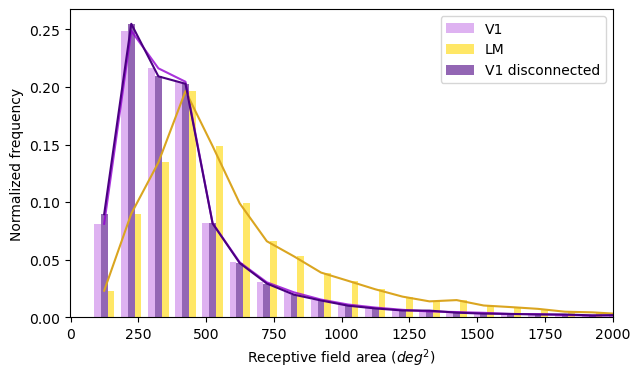

V1 median: 300.0
LM median: 500.0
V1 disconnected median: 300.0

V1 mean: 399.88201160541587
LM mean: 604.0226707215925
V1 disconnected mean: 396.0516547493455


In [7]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,4))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Normalized frequency')
plt.xlim(-1, 2000)
plt.legend()
plt.show()

# print the medians
print('V1 median:', np.nanmedian(rf_areas_v1))
print('LM median:', np.nanmedian(rf_areas_lm))
print('V1 disconnected median:', np.nanmedian(rf_areas_v1_dis))

# print the means
print()
print('V1 mean:', np.nanmean(rf_areas_v1))
print('LM mean:', np.nanmean(rf_areas_lm))
print('V1 disconnected mean:', np.nanmean(rf_areas_v1_dis))

#### Add properties to csv database

In [8]:
# add a column to df_v1 with the RF areas
df_v1['RF_area'] = rf_areas_v1
df_lm['RF_area'] = rf_areas_lm

# add center of mass position
df_v1['RF_center'] = list(center_of_mass_v1)
df_lm['RF_center'] = list(center_of_mass_lm)

# add inverse RF or not as True or False depending if the index is in the inverse_indices list
df_v1['Inverse_RF'] = df_v1.index.isin(inverse_indices_v1)
df_lm['Inverse_RF'] = df_lm.index.isin(inverse_indices_lm)

## By neuron type

In [9]:
# Now do it again but selecting only neurons from a given type
# Create the neuron types mask
# obtain the neuron type of each neuron 
new_pop_names = other_billeh_utils.pop_names(networks['v1'], n_selected_neurons=51978, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_v1 = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]
new_pop_names = other_billeh_utils.pop_names(networks['lm'], n_selected_neurons=7414, data_dir='/home/sofiagil/tfm/LM_V1_Billeh_model_sofia/GLIF_network')
cell_types_lm = [other_billeh_utils.pop_name_to_cell_type(pop_name) for pop_name in new_pop_names]

unique_cell_types = list(set(cell_types_v1))
unique_cell_types = sorted(unique_cell_types)

layer_mask_v1_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types_v1] for i in range(len(unique_cell_types))]
layer_mask_lm_types = [[cell_type == unique_cell_types[i] for cell_type in cell_types_lm] for i in range(len(unique_cell_types))]

# Select the neuron type to filter
t = 1
type = unique_cell_types[t]
print("You have selected the type: ", type)

# select the given neuron type receptive field
rf_areas_type_v1 = rf_areas_v1[layer_mask_v1_types[t]]
rf_areas_type_lm = rf_areas_lm[layer_mask_lm_types[t]]
rf_areas_type_v1_dis = rf_areas_v1_dis[layer_mask_v1_types[t]]

You have selected the type:  L2/3 Exc


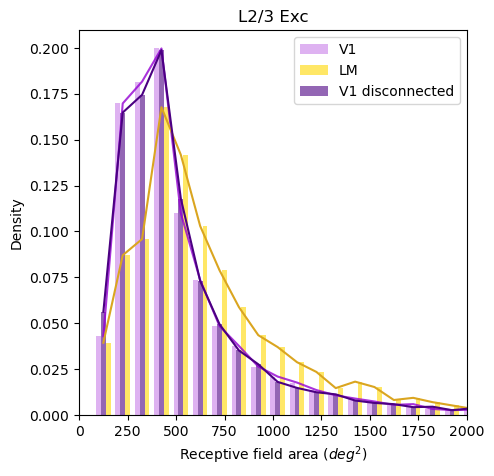

Median V1 RF area: 400.0
Median LM RF area: 500.0
Median V1 disconnected RF area: 400.0

Mean V1 RF area: 512.6377135558039
Mean LM RF area: 644.1176470588235
Mean V1 disconnected RF area: 506.13381377446564


In [10]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_type_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_type_lm, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_type_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (5,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Density')
plt.xlim(-1, 2000)
# put neuron type as title
plt.title(type)
plt.legend()
plt.show()

# print the medians
print('Median V1 RF area:', np.nanmedian(rf_areas_type_v1))
print('Median LM RF area:', np.nanmedian(rf_areas_type_lm))
print('Median V1 disconnected RF area:', np.nanmedian(rf_areas_type_v1_dis))

# print the means
print()
print('Mean V1 RF area:', np.nanmean(rf_areas_type_v1))
print('Mean LM RF area:', np.nanmean(rf_areas_type_lm))
print('Mean V1 disconnected RF area:', np.nanmean(rf_areas_type_v1_dis))

## For all excitatory neurons

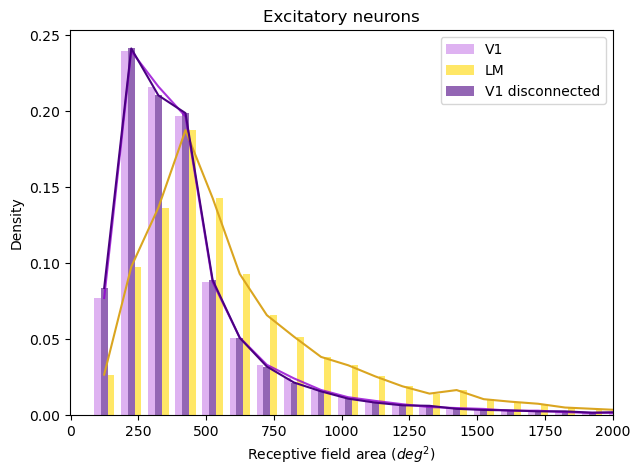

Median V1 RF area: 300.0
Median LM RF area: 500.0
Median V1 disconnected RF area: 300.0

Mean V1 RF area: 411.33155637965
Mean LM RF area: 607.5116588940706
Mean V1 disconnected RF area: 408.7557927257408


In [11]:
# Now do it for all excitatory neurons together: L2/3 Exc, L4 Exc, L5 Exc, L6 Exc
types = [1, 5, 9, 13]

rf_areas_exc_v1 = np.zeros((0))
rf_areas_exc_lm = np.zeros((0))
rf_areas_exc_v1_dis = np.zeros((0))

for t in types:
    rf_areas_exc_v1 = np.concatenate((rf_areas_exc_v1, rf_areas_v1[layer_mask_v1_types[t]]))
    rf_areas_exc_lm = np.concatenate((rf_areas_exc_lm, rf_areas_lm[layer_mask_lm_types[t]]))
    rf_areas_exc_v1_dis = np.concatenate((rf_areas_exc_v1_dis, rf_areas_v1_dis[layer_mask_v1_types[t]]))

# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_exc_v1, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_exc_lm, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_exc_v1_dis, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)')
plt.ylabel('Density')
plt.xlim(-1, 2000)
# put neuron type as title
plt.title('Excitatory neurons')
plt.legend()

# # compute quartile 1 and 3
# q1_v1 = np.percentile(rf_areas_exc_v1, 5)
# q3_v1 = np.percentile(rf_areas_exc_v1, 95)
# q1_lm = np.percentile(rf_areas_exc_lm, 5)
# q3_lm = np.percentile(rf_areas_exc_lm, 95)
# q1_v1dis = np.percentile(rf_areas_exc_v1_dis, 5)
# q3_v1dis = np.percentile(rf_areas_exc_v1_dis, 95)

plt.show()

# print medians
print('Median V1 RF area:', np.nanmedian(rf_areas_exc_v1))
print('Median LM RF area:', np.nanmedian(rf_areas_exc_lm))
print('Median V1 disconnected RF area:', np.nanmedian(rf_areas_exc_v1_dis))

# # print average inside the 1st and 3rd quartile
# print()
# print('Average V1 RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_v1[(rf_areas_exc_v1 > q1_v1) & (rf_areas_exc_v1 < q3_v1)]))
# print('Average LM RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_lm[(rf_areas_exc_lm > q1_lm) & (rf_areas_exc_lm < q3_lm)]))
# print('Average V1 disconnected RF area inside 0.05 and 0.95 percentiles:', np.mean(rf_areas_exc_v1_dis[(rf_areas_exc_v1_dis > q1_v1dis) & (rf_areas_exc_v1_dis < q3_v1dis)]))

# print the means
print()
print('Mean V1 RF area:', np.nanmean(rf_areas_exc_v1))
print('Mean LM RF area:', np.nanmean(rf_areas_exc_lm))
print('Mean V1 disconnected RF area:', np.nanmean(rf_areas_exc_v1_dis))

# Null model

In [12]:
# load the trials data
with open('Data_connected/v1_sums_trials.pkl', 'rb') as f:
    v1_sums_trials = pkl.load(f)

with open('Data_connected/lm_sums_trials.pkl', 'rb') as f:
    lm_all_trials = pkl.load(f)

with open('Data_disconnected/v1_sums_trials.pkl', 'rb') as f:
    v1_sums_dis_trials = pkl.load(f)

## Visualization 1 neuron

In [13]:
# print shape of neuron_rf_trials
print('V1 shape:', v1_sums_trials[:,:,:,0].shape)

V1 shape: (13, 11, 50)


Expected value:  11.224895104895104
Real chi2:  0.7433630876043995
Null expected value:  11.186293706293707
One null chi2:  1.0005775345061907
Chi^2 p-value: 0.899


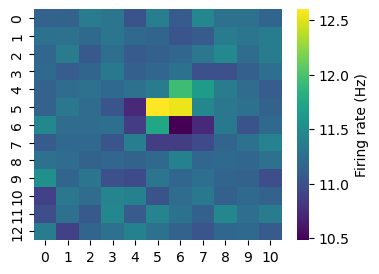

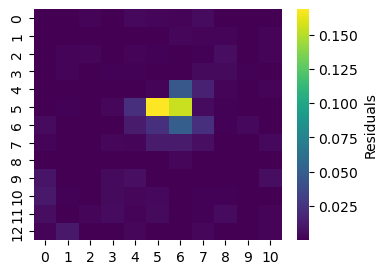

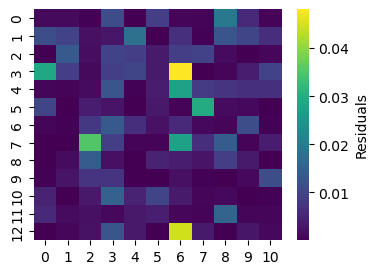

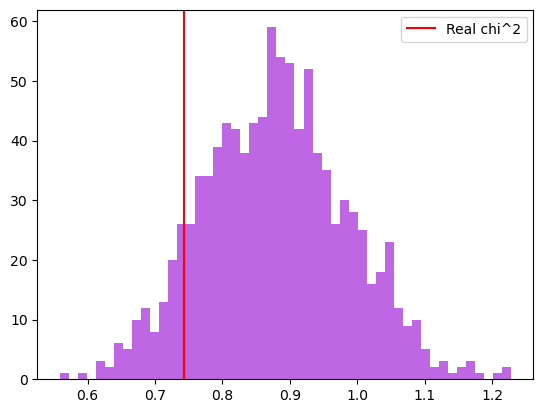

In [62]:
neuron = 20202

epsilon = 1e-6
n_shuffles = 1000
null_chi2_v1 = np.zeros((n_shuffles))

neuron_rf = np.copy(v1_sums[:,:,neuron]) # select the neuron
neuron_rf_trials = v1_sums_trials[:,:,:,neuron] # select the neuron

# set 0.0 values to percentile mean
expected_value = np.mean(neuron_rf)
print("Expected value: ", expected_value)

plt.figure(figsize=(4,3))
sns.heatmap(neuron_rf, cmap='viridis', cbar_kws={'label': 'Firing rate (Hz)'})

# compute residuals
residuals = (neuron_rf - expected_value)**2 / (expected_value + epsilon)

plt.figure(figsize=(4,3))
sns.heatmap(residuals, cmap='viridis', cbar_kws={'label': 'Residuals'})

real_chi2_v1 = np.sum(residuals)
print("Real chi2: ", real_chi2_v1)

for i in range(n_shuffles):
    # create a matrix to store the shuffled RFs
    shuffled_rf = np.zeros((n_rows, n_cols))

    flattened_arr = neuron_rf_trials.flatten()
    bootstrap_sample = np.random.choice(flattened_arr, size=flattened_arr.size, replace = True)
    bootstrap_arr = bootstrap_sample.reshape(neuron_rf_trials.shape)

    shuffled_rf = np.mean(bootstrap_arr, axis = 2)

    expected_value = np.mean(shuffled_rf)
    
    # compute residuals
    residuals = (shuffled_rf - expected_value)**2 / (expected_value)  # Add epsilon to avoid division by zero

    # compute chi^2
    null_chi2_v1[i] = np.sum(residuals)

# compute p-value
p_value_v1 = np.sum(null_chi2_v1 > real_chi2_v1) / n_shuffles
print("Null expected value: ", expected_value)
print("One null chi2: ", null_chi2_v1[0])
print('Chi^2 p-value:', p_value_v1)

# plot residuals
plt.figure(figsize=(4,3))
sns.heatmap(residuals, cmap='viridis', cbar_kws={'label': 'Residuals'})

plt.figure()
plt.hist(null_chi2_v1, bins=50, color='darkviolet', alpha=0.6)
plt.axvline(real_chi2_v1, color='red', label='Real chi^2')
plt.legend()
plt.show()

## Null model all neurons

In [15]:
# load chi2 values
n_shuffles = 1000

with open('Data_connected/real_chi2_v1_bootstrap.pkl', 'rb') as f:
    real_chi2_v1 = pkl.load(f)

with open('Data_connected/null_chi2_v1_bootstrap.pkl', 'rb') as f:
    null_chi2_v1 = pkl.load(f)

with open('Data_connected/real_chi2_lm_bootstrap.pkl', 'rb') as f:
    real_chi2_lm = pkl.load(f)

with open('Data_connected/null_chi2_lm_bootstrap.pkl', 'rb') as f:
    null_chi2_lm = pkl.load(f)

with open('Data_disconnected/real_chi2_v1_bootstrap.pkl', 'rb') as f:
    real_chi2_v1_dis = pkl.load(f)

with open('Data_disconnected/null_chi2_v1_bootstrap.pkl', 'rb') as f:
    null_chi2_v1_dis = pkl.load(f)

In [16]:
# Compute p-values
p_values_v1 = np.zeros((n_neurons_v1))
p_values_lm = np.zeros((n_neurons_lm))
p_values_v1_dis = np.zeros((n_neurons_v1))

for neuron in range(n_neurons_v1):
    p_values_v1[neuron] = np.sum(null_chi2_v1[neuron] > real_chi2_v1[neuron]) / n_shuffles

for neuron in range(n_neurons_lm):
    p_values_lm[neuron] = np.sum(null_chi2_lm[neuron] > real_chi2_lm[neuron]) / n_shuffles

for neuron in range(n_neurons_v1):
    p_values_v1_dis[neuron] = np.sum(null_chi2_v1_dis[neuron] > real_chi2_v1_dis[neuron]) / n_shuffles

# print amount of neurons with p-value < 0.05
percentage_v1 = np.sum(p_values_v1 < 0.05) / n_neurons_v1
percentage_lm = np.sum(p_values_lm < 0.05) / n_neurons_lm
percentage_v1_dis = np.sum(p_values_v1_dis < 0.05) / n_neurons_v1

print('Percentage of V1 neurons with p-value < 0.05:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.05:', percentage_lm)
print('Percentage of V1 disconnected neurons with p-value < 0.05:', percentage_v1_dis)

# print amount of neurons with p-value < 0.01
percentage_v1 = np.sum(p_values_v1 < 0.01) / n_neurons_v1
percentage_lm = np.sum(p_values_lm < 0.01) / n_neurons_lm
percentage_v1_dis = np.sum(p_values_v1_dis < 0.01) / n_neurons_v1

print('\n Percentage of V1 neurons with p-value < 0.01:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.01:', percentage_lm)
print('Percentage of V1 disconnected neurons with p-value < 0.01:', percentage_v1_dis)

# select significant neurons as p-value < p_value_th and rf_area < 2500
p_value_th = 0.01
significant_neurons_v1 = np.where((p_values_v1 < p_value_th) & (rf_areas_v1 < 2500) & (rf_areas_v1 > 0))[0]
significant_neurons_lm = np.where((p_values_lm < p_value_th) & (rf_areas_lm < 2500) & (rf_areas_lm > 0))[0]
significant_neurons_v1_dis = np.where((p_values_v1_dis < p_value_th) & (rf_areas_v1_dis < 2500) & (rf_areas_v1_dis > 0))[0]

# print the percentages of significant neurons
percentage_v1 = len(significant_neurons_v1) / n_neurons_v1
percentage_lm = len(significant_neurons_lm) / n_neurons_lm
percentage_v1_dis = len(significant_neurons_v1_dis) / n_neurons_v1

print('\n Percentage of V1 neurons with p-value < 0.01 and RF area < 2500:', percentage_v1)
print('Percentage of LM neurons with p-value < 0.01 and RF area < 2500:', percentage_lm)
print('Percentage of V1 disconnected neurons with p-value < 0.01 and RF area < 2500:', percentage_v1_dis)

# save significant indices in each region
with open('significant_neurons_v1.pkl', 'wb') as f:
    pkl.dump(significant_neurons_v1, f)

with open('significant_neurons_lm.pkl', 'wb') as f:
    pkl.dump(significant_neurons_lm, f)

with open('significant_neurons_v1_dis.pkl', 'wb') as f:
    pkl.dump(significant_neurons_v1_dis, f)

Percentage of V1 neurons with p-value < 0.05: 0.2305398437800608
Percentage of LM neurons with p-value < 0.05: 0.11640140275155111
Percentage of V1 disconnected neurons with p-value < 0.05: 0.23913963599984608

 Percentage of V1 neurons with p-value < 0.01: 0.197641309784909
Percentage of LM neurons with p-value < 0.01: 0.10089020771513353
Percentage of V1 disconnected neurons with p-value < 0.01: 0.2055485012890069

 Percentage of V1 neurons with p-value < 0.01 and RF area < 2500: 0.19723729270075802
Percentage of LM neurons with p-value < 0.01 and RF area < 2500: 0.09630428918262746
Percentage of V1 disconnected neurons with p-value < 0.01 and RF area < 2500: 0.20106583554580784


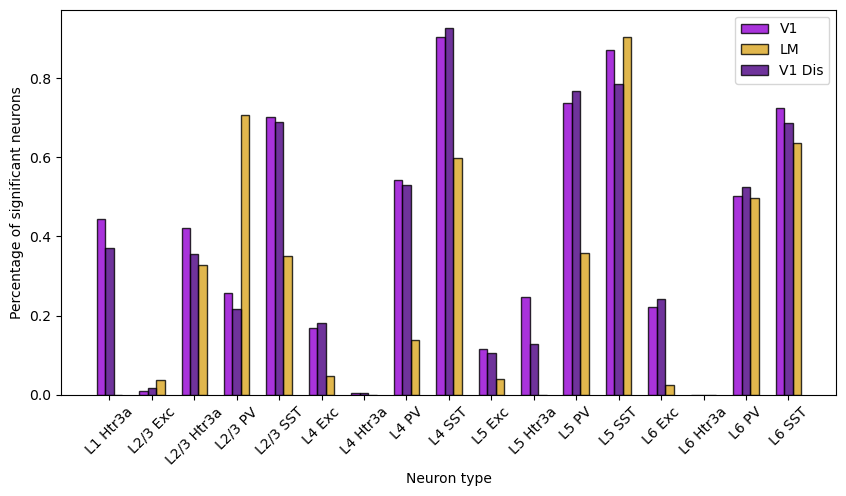

In [63]:
# apply it also to the neuron types
significant_cell_types_v1 = [cell_types_v1[neuron] for neuron in significant_neurons_v1]
significant_cell_types_lm = [cell_types_lm[neuron] for neuron in significant_neurons_lm]
significant_cell_types_v1_dis = [cell_types_v1[neuron] for neuron in significant_neurons_v1_dis]

# compute the percentage of significant neurons in each neuron type
percentage_v1 = np.zeros(len(unique_cell_types))
percentage_lm = np.zeros(len(unique_cell_types))
percentage_v1_dis = np.zeros(len(unique_cell_types))

for type in unique_cell_types:
    # count number of type in cell_types_v1
    n_type_v1 = cell_types_v1.count(type)
    n_type_lm = cell_types_lm.count(type)
    n_type_v1_dis = cell_types_v1.count(type)

    # count number of type in significant_cell_types_v1
    n_type_significant_v1 = significant_cell_types_v1.count(type)
    n_type_significant_lm = significant_cell_types_lm.count(type)
    n_type_significant_v1_dis = significant_cell_types_v1_dis.count(type)

    # compute the percentage
    percentage_v1[unique_cell_types.index(type)] = n_type_significant_v1 / n_type_v1
    percentage_lm[unique_cell_types.index(type)] = n_type_significant_lm / n_type_lm
    percentage_v1_dis[unique_cell_types.index(type)] = n_type_significant_v1_dis / n_type_v1_dis


# plot the percentage of significant neurons in each neuron type
plt.figure(figsize = (10,5))
bar_width = 0.2  # Define the width of the bars
x = np.arange(len(unique_cell_types))  # Define the x-coordinates of the bars

plt.bar(x - bar_width, percentage_v1, bar_width, color='darkviolet', label='V1', alpha=0.8, edgecolor='black')
plt.bar(x + bar_width, percentage_lm, bar_width, color='goldenrod', label='LM', alpha=0.8, edgecolor='black')
plt.bar(x , percentage_v1_dis, bar_width, color='indigo', label='V1 Dis', alpha=0.8, edgecolor='black')

plt.xticks(x, unique_cell_types, rotation=45)   # Set the x-ticks to the middle of the bars
plt.xlabel('Neuron type')
plt.ylabel('Percentage of significant neurons')
plt.legend()
plt.show()

In [64]:
# add column of significant neurons to the dataframes
df_v1['Significant_RF'] = df_v1.index.isin(significant_neurons_v1)
df_lm['Significant_RF'] = df_lm.index.isin(significant_neurons_lm)

# save as v1_features_rf.csv and lm_features_rf.csv
df_v1.to_csv('v1_features_rf.csv')
df_lm.to_csv('lm_features_rf.csv')

# RF computation for all significant neurons

In [65]:
# Filter the rf_areas_v1 and rf_areas_lm with the significant neurons
rf_areas_v1_significant = rf_areas_v1[significant_neurons_v1]
rf_areas_lm_significant = rf_areas_lm[significant_neurons_lm]
rf_areas_v1_dis_significant = rf_areas_v1_dis[significant_neurons_v1_dis]

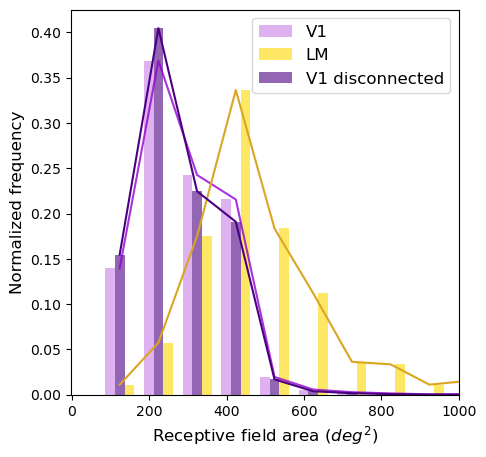

Median V1 RF area: 200.0
Median LM RF area: 400.0
Median V1 disconnected RF area: 200.0

Mean V1 RF area: 268.5524775653531
Mean LM RF area: 471.7086834733893
Mean V1 disconnected RF area: 255.92766242464836


In [66]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm_significant, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_v1_dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (5,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize=12)
plt.ylabel('Normalized frequency', fontsize=12)
plt.xlim(-1, 1000)
plt.legend(fontsize = 12)

plt.show()

# compute the median
median_v1 = np.median(rf_areas_v1_significant)
median_lm = np.median(rf_areas_lm_significant)
median_v1dis = np.median(rf_areas_v1_dis_significant)

print('Median V1 RF area:', median_v1)
print('Median LM RF area:', median_lm)
print('Median V1 disconnected RF area:', median_v1dis)

# compute the mean
mean_v1 = np.mean(rf_areas_v1_significant)
mean_lm = np.mean(rf_areas_lm_significant)
mean_v1dis = np.mean(rf_areas_v1_dis_significant)

print()
print('Mean V1 RF area:', mean_v1)
print('Mean LM RF area:', mean_lm)
print('Mean V1 disconnected RF area:', mean_v1dis)

(-1.0, 1500.0)

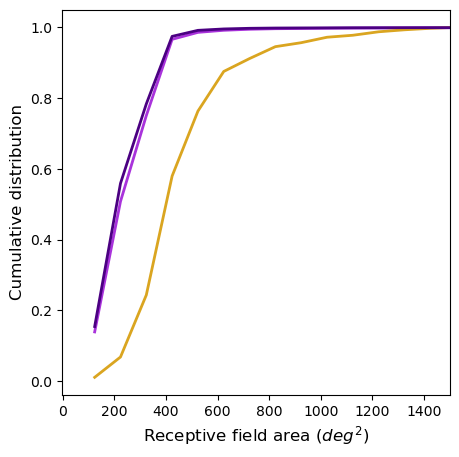

In [68]:
# Define bin edges and centers
plt.figure(figsize=(5,5))
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_lm_significant, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_v1_dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Calculate cumulative sums
cumsum_v1 = np.cumsum(hist_v1)
cumsum_lm = np.cumsum(hist_lm)
cumsum_v1_dis = np.cumsum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], cumsum_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8, linewidth = 2)
plt.plot(bin_centers[hist_lm > 0], cumsum_lm[hist_lm > 0], color='goldenrod', linewidth = 2)
plt.plot(bin_centers[hist_v1_dis > 0], cumsum_v1_dis[hist_v1_dis > 0], color='indigo', linewidth = 2)

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize = 12)
plt.ylabel('Cumulative distribution', fontsize = 12)
plt.xlim(-1, 1500)
# plt.legend()

In [69]:
def get_bootstrap_95ci(M, measure_of_central_tendency, N=1000):
    n = int(len(M)/2)
    est = np.zeros((N,))
    for i in range(N):
        boot = M[np.random.permutation(len(M))[:n]]
        est[i] = measure_of_central_tendency(boot)
        
    return np.percentile(est,97.5) - np.nanmean(est)

# compute the 95% confidence interval for the mean
ci_v1 = get_bootstrap_95ci(rf_areas_v1_significant, np.mean)
ci_lm = get_bootstrap_95ci(rf_areas_lm_significant, np.mean)
ci_v1_dis = get_bootstrap_95ci(rf_areas_v1_dis_significant, np.mean)

print()
print('95% confidence interval for the mean V1:', ci_v1)
print('95% confidence interval for the mean LM:', ci_lm)
print('95% confidence interval for the mean V1 disconnected:', ci_v1_dis)


95% confidence interval for the mean V1: 2.7730003901677946
95% confidence interval for the mean LM: 14.588515406162458
95% confidence interval for the mean V1 disconnected: 2.4861818181818194


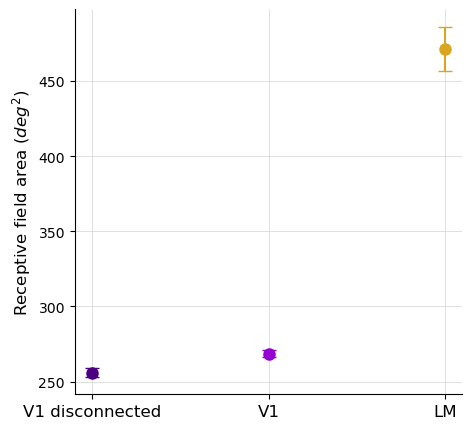

In [70]:
# Create a figure
plt.figure(figsize=(5,5))
x = ["V1 disconnected", "V1", "LM"]
colors = ['indigo', 'darkviolet', 'goldenrod']
y = [mean_v1dis, mean_v1, mean_lm]
errors = [ci_v1, ci_v1_dis, ci_lm]

for i in range(len(x)):
    plt.errorbar(x[i], y[i], yerr=errors[i], fmt='o', capsize=5, markersize=8, color=colors[i])

plt.ylabel(r'Receptive field area ($deg^2$)', fontsize = 12)

# Add a light grey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove top and right axes
ax = plt.gca()  # gca stands for 'get current axis'
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

plt.xticks(fontsize = 12)

plt.show()

## RF significant neurons by types

In [79]:
# update the layers mask to include only significant neurons
layer_mask_v1_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_v1] for i in range(len(unique_cell_types))]
layer_mask_lm_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_lm] for i in range(len(unique_cell_types))]
layer_mask_v1dis_types_significant = [[cell_type == unique_cell_types[i] for cell_type in significant_cell_types_v1_dis] for i in range(len(unique_cell_types))]

# Select the neuron type to filter
t = 1
type = unique_cell_types[t]
print("You have selected the type: ", type)

# select the given neuron type receptive field
rf_areas_type_v1_significant = rf_areas_v1_significant[layer_mask_v1_types_significant[t]]
rf_areas_type_lm_significant = rf_areas_lm_significant[layer_mask_lm_types_significant[t]]
rf_areas_type_v1dis_significant = rf_areas_v1_dis_significant[layer_mask_v1dis_types_significant[t]]

You have selected the type:  L2/3 Exc


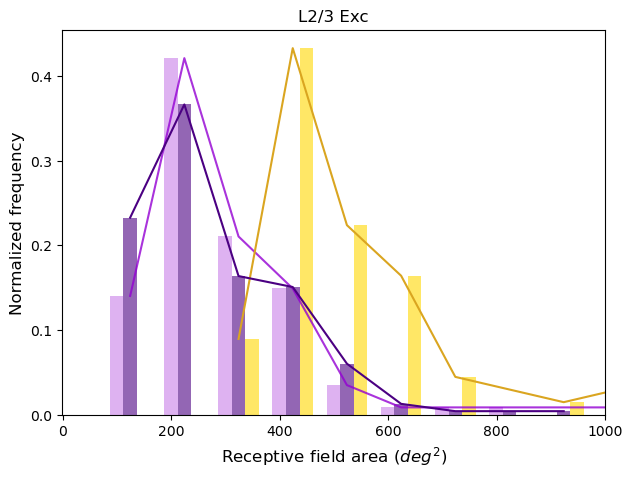

Median V1 RF area: 200.0
Median LM RF area: 400.0
Median V1 disconnected RF area: 200.0
Mean V1 RF area: 277.1929824561403
Mean LM RF area: 485.07462686567163
Mean V1 disconnected RF area: 254.31034482758622


In [80]:
# Define bin edges and centers
bin_edges = np.arange(-1, 100*100, 50)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate histograms
hist_v1, _ = np.histogram(rf_areas_type_v1_significant, bins=bin_edges)
hist_lm, _ = np.histogram(rf_areas_type_lm_significant, bins=bin_edges)
hist_v1_dis, _ = np.histogram(rf_areas_type_v1dis_significant, bins=bin_edges)

# Normalize histograms
hist_v1 = hist_v1 / np.sum(hist_v1)
hist_lm = hist_lm / np.sum(hist_lm)
hist_v1_dis = hist_v1_dis / np.sum(hist_v1_dis)

# Width of each bar
width = (bin_edges[1] - bin_edges[0]) / 2

# Create bar plots
plt.figure(figsize = (7,5))
plt.bar(bin_centers - width, hist_v1, width=width, color='darkviolet', label='V1', alpha=0.3)
plt.bar(bin_centers + width, hist_lm, width=width, color='gold', label='LM', alpha=0.6)
plt.bar(bin_centers, hist_v1_dis, width=width, color='indigo', label='V1 disconnected', alpha=0.6)

# Create line plots for non-zero values
plt.plot(bin_centers[hist_v1 > 0], hist_v1[hist_v1 > 0], color='darkviolet', alpha = 0.8)
plt.plot(bin_centers[hist_lm > 0], hist_lm[hist_lm > 0], color='goldenrod')
plt.plot(bin_centers[hist_v1_dis > 0], hist_v1_dis[hist_v1_dis > 0], color='indigo')

plt.xlabel(r'Receptive field area ($deg^2$)', fontsize = 12)
plt.ylabel('Normalized frequency', fontsize = 12)
plt.xlim(-1, 1000)
# put neuron type as title
plt.title(type)
# plt.legend()

plt.show()

# print the medians
print('Median V1 RF area:', np.median(rf_areas_type_v1_significant))
print('Median LM RF area:', np.median(rf_areas_type_lm_significant))
print('Median V1 disconnected RF area:', np.median(rf_areas_type_v1dis_significant))

# print the means
print('Mean V1 RF area:', np.mean(rf_areas_type_v1_significant))
print('Mean LM RF area:', np.mean(rf_areas_type_lm_significant))
print('Mean V1 disconnected RF area:', np.mean(rf_areas_type_v1dis_significant))